In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pandas as pd


task_conditions = [
    {"source": "CWRU_0", "target": "CWRU_1", "name": "T1(1730->1750)"},
    {"source": "CWRU_0", "target": "CWRU_2", "name": "T2(1730->1772)"},
    {"source": "CWRU_1", "target": "CWRU_0", "name": "T3(1750->1730)"},
    {"source": "CWRU_1", "target": "CWRU_2", "name": "T4(1750->1772)"},
    {"source": "CWRU_2", "target": "CWRU_0", "name": "T5(1772->1730)"},
    {"source": "CWRU_2", "target": "CWRU_1", "name": "T6(1772->1750)"},
    {"source": "JNU_0", "target": "JNU_1", "name": "T1(600>800)"},
    {"source": "JNU_0", "target": "JNU_2", "name": "T2(600->1000)"},
    {"source": "JNU_1", "target": "JNU_0", "name": "T3(800->600)"},
    {"source": "JNU_1", "target": "JNU_2", "name": "T4(800->1000)"},
    {"source": "JNU_2", "target": "JNU_0", "name": "T5(1000->600)"},
    {"source": "JNU_2", "target": "JNU_1", "name": "T6(1000->800)"},
    {"source": "SEU_0", "target": "SEU_1", "name": "T1(100->200)"},
    {"source": "SEU_1", "target": "SEU_0", "name": "T2(200->100)"},

]


def plot_radar_chart(data, title, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
        
        
    for condition in task_conditions:
        data.loc[  (data["source"] == condition["source"]) & 
                (data["target"] == condition["target"]), "Task"] = condition["name"]
        
    data['Task_Order'] = data['Task'].str.extract('(\d+)').astype(int)
    

    # Task_Order를 기준으로 정렬
    data = data.sort_values(['Task_Order', 'Task']).drop(columns=['Task_Order'])

    # Name 목록 추출
    names = data['Name'].unique()
    
    # Task 목록 추출
    tasks = data['Task'].unique()
    
    # 모델별 평균 성능 계산
    model_means = data.groupby('Name')[['Task', 'last_target_acc']].apply(lambda x: x.set_index('Task').expanding().mean().reset_index())
    model_means = model_means.groupby('Name').last().reset_index()
    model_means['Task'] = 'Average'
    print(model_means.sort_values('last_target_acc', ascending=False))


    # 데이터에 모델별 평균 성능 추가
    data = pd.concat([data, model_means], ignore_index=True)
    
    # 업데이트된 Task 목록 추출
    tasks = np.append(tasks, 'Average')
    
    # 레이더 차트 그리기
    angles = np.linspace(0, 2 * np.pi, len(tasks), endpoint=False).tolist()
    angles += angles[:1]  # 마지막 각도 추가하여 폐쇄형 다각형 만들기
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    

    for i in range(1, 6):
        ax.plot(angles, [i * 0.2] * len(angles), '-', color="gray", lw=0.5)
        ax.text(0, i * 0.2, "{:.1f}".format(i * 0.2), color="gray", size=15, ha='center', va='center')  # 레이블 추가
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels=tasks, fontsize=14)
    ax.yaxis.set_tick_params(labelsize=0)
    for name in names:
        name_data = data[data['Name'] == name]
        values = [name_data[name_data['Task'] == task]['last_target_acc'].values[0] if len(name_data[name_data['Task'] == task]) > 0 else 0 for task in tasks]
        values += values[:1]  # 첫 번째 값을 마지막에 추가하여 폐쇄형 다각형 데이터 포인트 만들기
        
        
        ax.plot(angles, values, linewidth=3, linestyle='solid', label=name, marker='o', markersize=5)  # 마커 추가
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_ylim(0, 1.0)  # 적절한 최대값으로 설정
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=20)
    
    ax.grid(False)
    ax.set_title(title, size=20)
    
    return fig, ax


def fetch_runs_summary(project_path):
    """
    Fetch summary information for all runs in a specified W&B project and return as a pandas DataFrame.
    
    Parameters:
        project_path (str): The path to the W&B project in the format 'entity/project'.
        
    Returns:
        pd.DataFrame: A DataFrame containing the run summaries.
    """

    # wandb 로그인
    wandb.login()
    
    # wandb API 객체 생성
    api = wandb.Api()
    
    # 프로젝트 내의 모든 runs 가져오기
    runs = api.runs(project_path)
    
    # 데이터프레임으로 저장할 빈 리스트 생성
    data = []
    
    # 각 run의 summary 정보 추출
    for run in runs:
        
        
        # 데이터프레임에 저장할 정보 선택 및 예외 처리
        data.append({
            "Name": run.config.get("model_name", None),  # 'model_name'이 없는 경우 None으로 처리        
            'unlabeled_target_size': run.summary.get('Validation Set Size', None),
            'source': run.config.get('source', None),
            'target': run.config.get('target', None),
            "best_target_acc": run.summary.get("best_target_acc", None),  # 'best_target_acc'가 없는 경우 None으로 처리
            "last_target_acc": run.summary.get("last_target_acc", None),  # 'last_target_acc'가 없는 경우 None으로 처리
            "Correct_Accuracy": run.summary.get("correct_target_acc", None),  # 'correct_target_acc'가 없는 경우 None으로 처리
        })
    
    # 리스트를 데이터프레임으로 변환
    df = pd.DataFrame(data)
    
    # 'proposed' 행의 'Correct_Accuracy' 값을 'last_target_acc'에 붙여넣기
   # df.loc[df['Name'] == 'proposed', 'last_target_acc'] = df['Correct_Accuracy']

    # 'Correct_Accuracy' 컬럼 삭제
   # df.drop('Correct_Accuracy', axis=1, inplace=True)

    
    
    return df





In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pandas as pd


task_conditions = [
    {"source": "CWRU_0", "target": "CWRU_1", "name": "T1(1730->1750)"},
    {"source": "CWRU_0", "target": "CWRU_2", "name": "T2(1730->1772)"},
    {"source": "CWRU_1", "target": "CWRU_0", "name": "T3(1750->1730)"},
    {"source": "CWRU_1", "target": "CWRU_2", "name": "T4(1750->1772)"},
    {"source": "CWRU_2", "target": "CWRU_0", "name": "T5(1772->1730)"},
    {"source": "CWRU_2", "target": "CWRU_1", "name": "T6(1772->1750)"},
    {"source": "JNU_0", "target": "JNU_1", "name": "T1(600>800)"},
    {"source": "JNU_0", "target": "JNU_2", "name": "T2(600->1000)"},
    {"source": "JNU_1", "target": "JNU_0", "name": "T3(800->600)"},
    {"source": "JNU_1", "target": "JNU_2", "name": "T4(800->1000)"},
    {"source": "JNU_2", "target": "JNU_0", "name": "T5(1000->600)"},
    {"source": "JNU_2", "target": "JNU_1", "name": "T6(1000->800)"},
    {"source": "SEU_0", "target": "SEU_1", "name": "T1(100->200)"},
    {"source": "SEU_1", "target": "SEU_0", "name": "T2(200->100)"},

]


def plot_radar_chart(data, title, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
        
        
    for condition in task_conditions:
        data.loc[  (data["source"] == condition["source"]) & 
                (data["target"] == condition["target"]), "Task"] = condition["name"]
        
    data['Task_Order'] = data['Task'].str.extract('(\d+)').astype(int)
    

    # Task_Order를 기준으로 정렬
    data = data.sort_values(['Task_Order', 'Task']).drop(columns=['Task_Order'])

    # Name 목록 추출
    names = data['Name'].unique()
    
    # Task 목록 추출
    tasks = data['Task'].unique()
    
    # 모델별 평균 성능 계산
    model_means = data.groupby('Name')[['Task', 'Correct_Accuracy']].apply(lambda x: x.set_index('Task').expanding().mean().reset_index())
    model_means = model_means.groupby('Name').last().reset_index()
    model_means['Task'] = 'Average'
    print(model_means.sort_values('Correct_Accuracy', ascending=False))


    # 데이터에 모델별 평균 성능 추가
    data = pd.concat([data, model_means], ignore_index=True)
    
    # 업데이트된 Task 목록 추출
    tasks = np.append(tasks, 'Average')
    
    # 레이더 차트 그리기
    angles = np.linspace(0, 2 * np.pi, len(tasks), endpoint=False).tolist()
    angles += angles[:1]  # 마지막 각도 추가하여 폐쇄형 다각형 만들기
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    

    for i in range(1, 6):
        ax.plot(angles, [i * 0.2] * len(angles), '-', color="gray", lw=0.5)
        ax.text(0, i * 0.2, "{:.1f}".format(i * 0.2), color="gray", size=15, ha='center', va='center')  # 레이블 추가
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels=tasks, fontsize=14)
    ax.yaxis.set_tick_params(labelsize=0)
    for name in names:
        name_data = data[data['Name'] == name]
        values = [name_data[name_data['Task'] == task]['Correct_Accuracy'].values[0] if len(name_data[name_data['Task'] == task]) > 0 else 0 for task in tasks]
        values += values[:1]  # 첫 번째 값을 마지막에 추가하여 폐쇄형 다각형 데이터 포인트 만들기
        
        
        ax.plot(angles, values, linewidth=3, linestyle='solid', label=name, marker='o', markersize=5)  # 마커 추가
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_ylim(0, 1.0)  # 적절한 최대값으로 설정
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=20)
    
    ax.grid(False)
    ax.set_title(title, size=20)
    
    return fig, ax


def fetch_runs_summary(project_path):
    """
    Fetch summary information for all runs in a specified W&B project and return as a pandas DataFrame.
    
    Parameters:
        project_path (str): The path to the W&B project in the format 'entity/project'.
        
    Returns:
        pd.DataFrame: A DataFrame containing the run summaries.
    """

    # wandb 로그인
    wandb.login()
    
    # wandb API 객체 생성
    api = wandb.Api()
    
    # 프로젝트 내의 모든 runs 가져오기
    runs = api.runs(project_path)
    
    # 데이터프레임으로 저장할 빈 리스트 생성
    data = []
    
    # 각 run의 summary 정보 추출
    for run in runs:
        
        
        # 데이터프레임에 저장할 정보 선택 및 예외 처리
        data.append({
            "Name": run.config.get("model_name", None),  # 'model_name'이 없는 경우 None으로 처리        
            'unlabeled_target_size': run.summary.get('Validation Set Size', None),
            'source': run.config.get('source', None),
            'target': run.config.get('target', None),
            #"best_target_acc": run.summary.get("best_target_acc", None),  # 'best_target_acc'가 없는 경우 None으로 처리
            "Correct_Accuracy": run.summary.get("correct_target_acc", None)  # 'last_target_acc'가 없는 경우 None으로 처리
            
        })
    
    # 리스트를 데이터프레임으로 변환
    df = pd.DataFrame(data)
    
    # 'proposed' 행의 'Correct_Accuracy' 값을 'last_target_acc'에 붙여넣기
    #df.loc[df['Name'] == 'proposed', 'last_target_acc'] = df['Correct_Accuracy']

    # 'Correct_Accuracy' 컬럼 삭제
    #df.drop('Correct_Accuracy', axis=1, inplace=True)

    
    
    return df





       Name     Task  Correct_Accuracy
5  proposed  Average          0.896333
4      DANN  Average          0.879833
0    ACDANN  Average          0.849667
2       CNN  Average          0.838000
1      CDAN  Average          0.809667
3     CORAL  Average          0.801333
       Name     Task  Correct_Accuracy
0    ACDANN  Average          0.947500
4      DANN  Average          0.928833
5  proposed  Average          0.922167
1      CDAN  Average          0.919500
3     CORAL  Average          0.911667
2       CNN  Average          0.862167


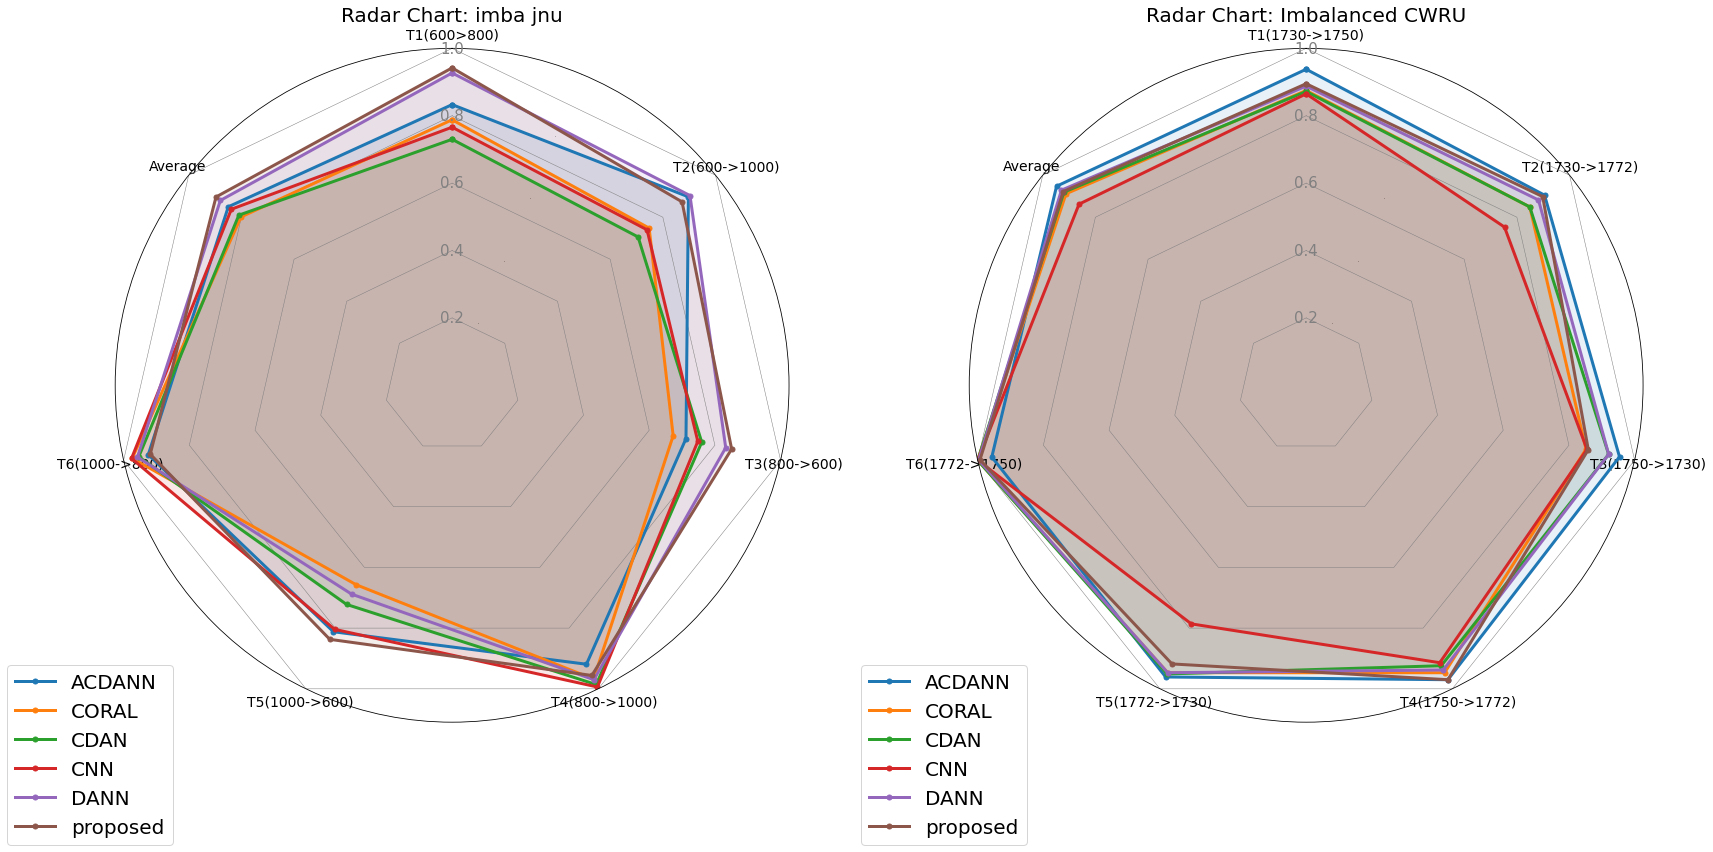

In [5]:
# CWRU
# train 590개 (클래스 10개, 각 클래스는 59개)
# unlabeld target 290개 (각 클래스는 29개) - unlabeld imbalanced target은 74개로 정상을 제외한 결함들은 20퍼센트씩 존재 정상 29개, 나머지 9개 클래스는 5개씩있음
# eval target 290개 (각 클래스는 29개)

path = "dsym2894/JNU_imba"
df1 = fetch_runs_summary(path)

path = "dsym2894/CWRU_imba"
df2 = fetch_runs_summary(path)



# 레이더 차트 그리기
fig, axs = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=dict(polar=True))
plot_radar_chart(df1, 'Radar Chart: imba jnu', fig, axs[0])
plot_radar_chart(df2, 'Radar Chart: Imbalanced CWRU', fig, axs[1])

plt.tight_layout()
plt.show()

       Name     Task  Correct_Accuracy
1      CDAN  Average            0.4280
2       CNN  Average            0.4165
4      DANN  Average            0.3555
5  proposed  Average            0.3315
3     CORAL  Average            0.3255
0    ACDANN  Average            0.3235
       Name     Task  Correct_Accuracy
1      CDAN  Average            0.4280
2       CNN  Average            0.4165
4      DANN  Average            0.3555
5  proposed  Average            0.3315
3     CORAL  Average            0.3255
0    ACDANN  Average            0.3235


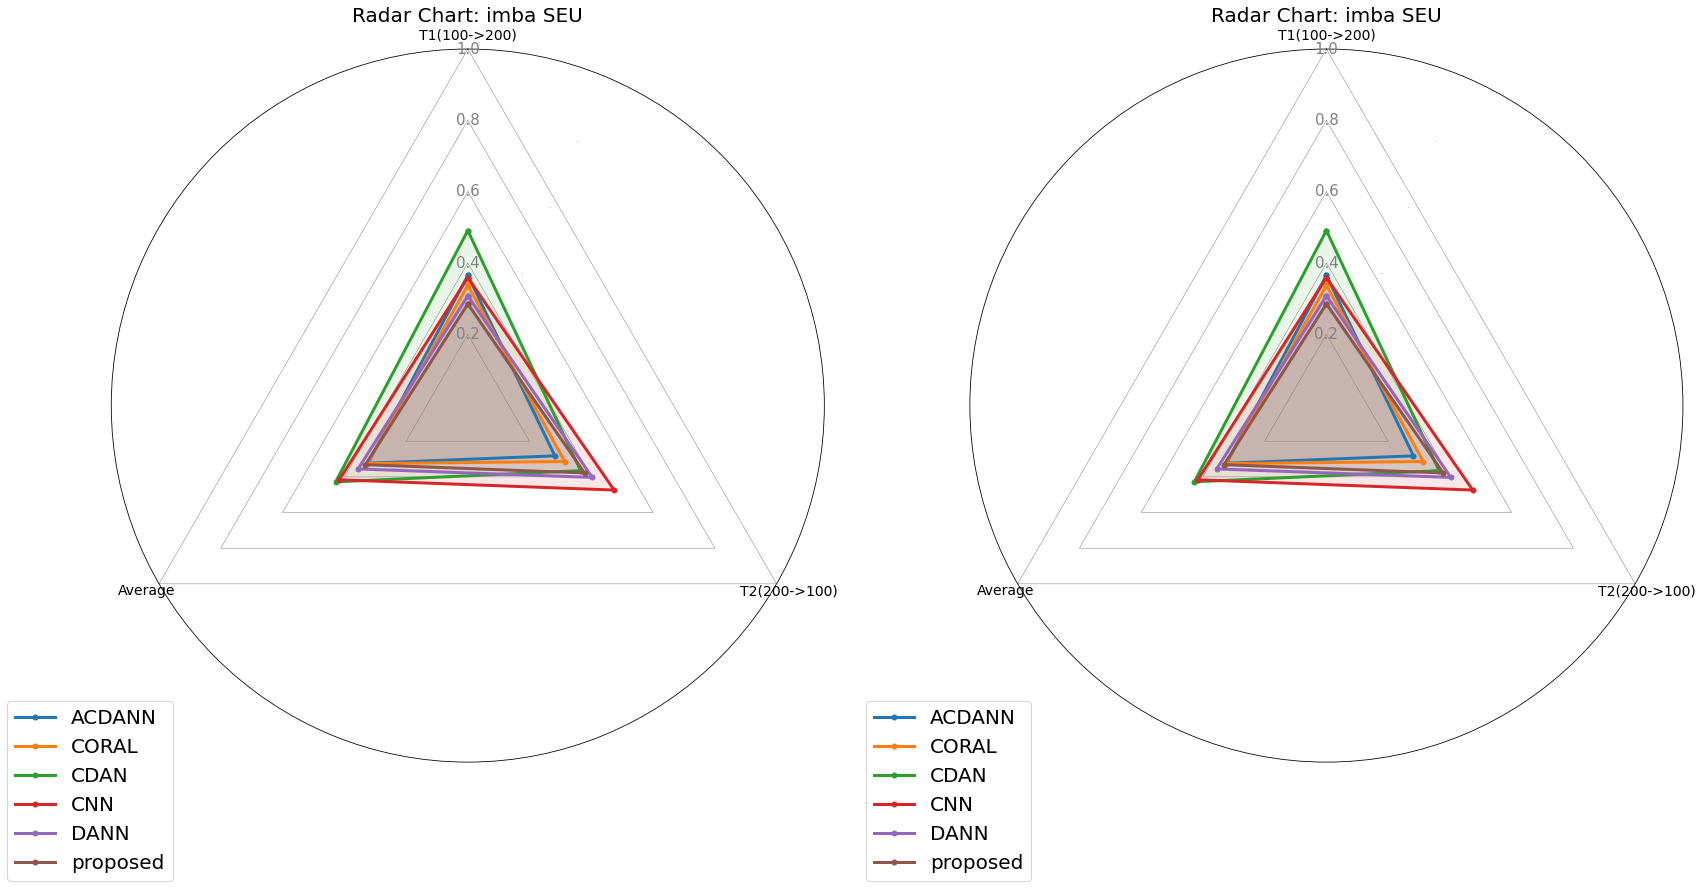

In [6]:
# CWRU
# train 590개 (클래스 10개, 각 클래스는 59개)
# unlabeld target 290개 (각 클래스는 29개) - unlabeld imbalanced target은 74개로 정상을 제외한 결함들은 20퍼센트씩 존재 정상 29개, 나머지 9개 클래스는 5개씩있음
# eval target 290개 (각 클래스는 29개)

path = "dsym2894/SEU_imba"
df1 = fetch_runs_summary(path)

path = "dsym2894/SEU_imba"
df2 = fetch_runs_summary(path)


# 레이더 차트 그리기
fig, axs = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=dict(polar=True))
plot_radar_chart(df1, 'Radar Chart: imba SEU', fig, axs[0])
plot_radar_chart(df2, 'Radar Chart: imba SEU', fig, axs[1])

plt.tight_layout()
plt.show()

       Name     Task  last_target_acc
5  proposed  Average         0.944000
4      DANN  Average         0.900833
2       CNN  Average         0.744000
0    ACDANN  Average         0.726500
1      CDAN  Average         0.688333
3     CORAL  Average         0.667833
       Name     Task  last_target_acc
2       CNN  Average         0.744000
4      DANN  Average         0.683333
5  proposed  Average         0.608333
1      CDAN  Average         0.400000
0    ACDANN  Average         0.346667
3     CORAL  Average         0.337167


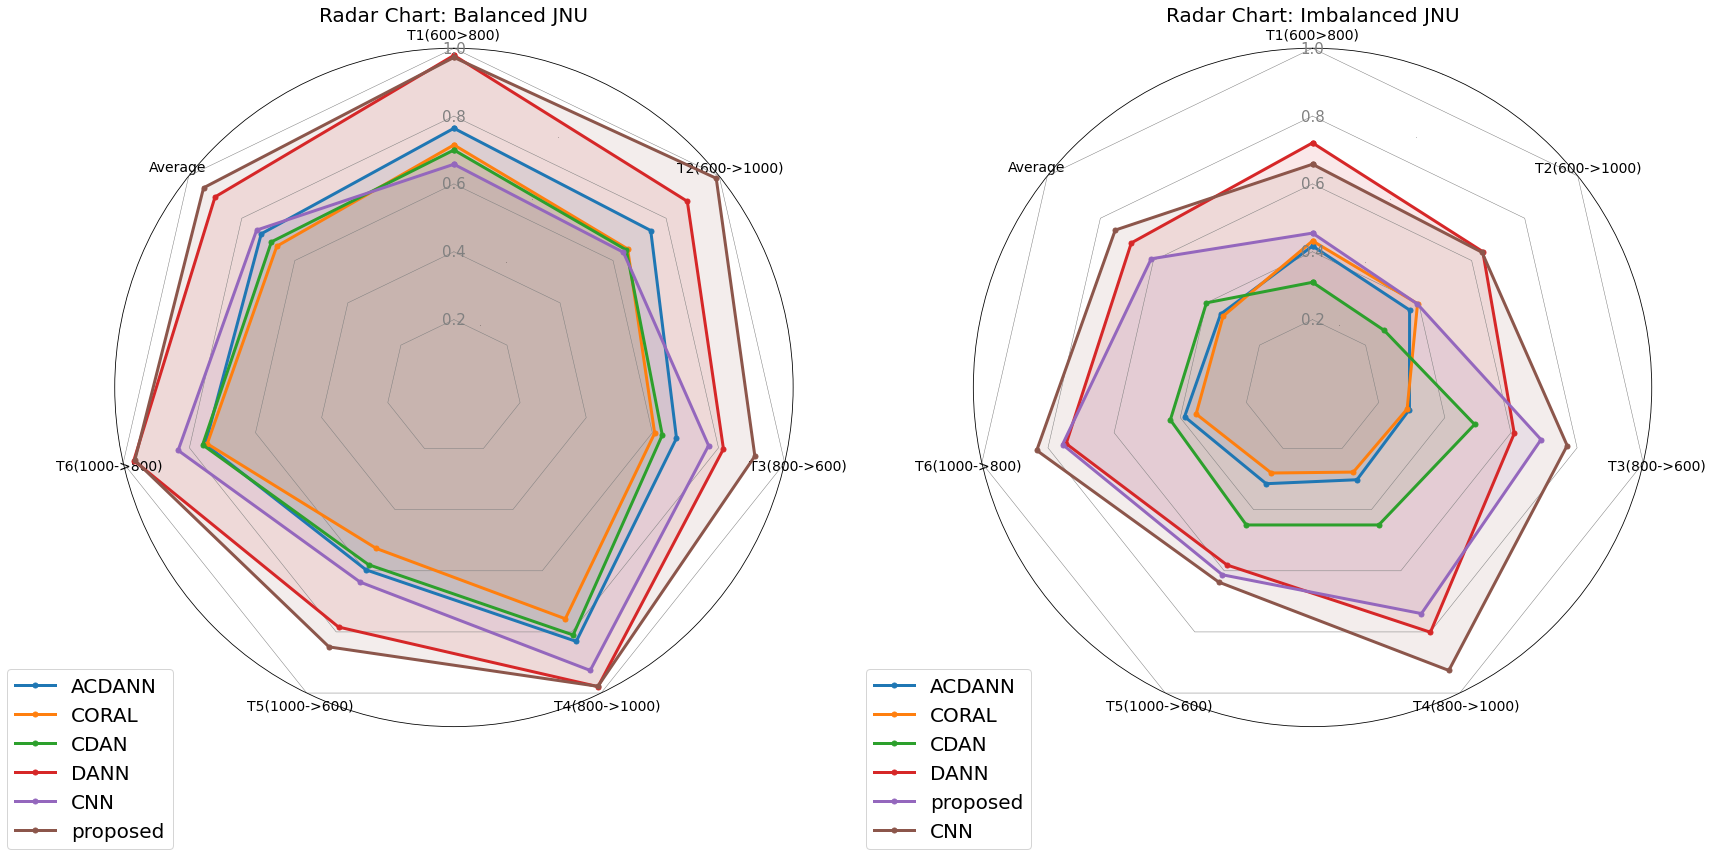

In [3]:
# JNU
# train 976개 (클래스 4개, 각 클래스는 244개)
# unlabeld target 488개 (각 클래스는 122개) - unlabeld imbalanced target은 140개로 정상을 제외한 결함들은 5퍼센트씩 존재 정상 122개, 나머지 3개 클래스는 6개씩있음
# eval target 488개 (각 클래스는 122개)

path = "dsym2894/JNU_NEW"
df1 = fetch_runs_summary(path)

path = "dsym2894/JNU_imba"
df2 = fetch_runs_summary(path)

# 레이더 차트 그리기
fig, axs = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=dict(polar=True))
plot_radar_chart(df1, 'Radar Chart: Balanced JNU', fig, axs[0])
plot_radar_chart(df2, 'Radar Chart: Imbalanced JNU', fig, axs[1])

plt.tight_layout()
plt.show()

       Name     Task  last_target_acc
5  proposed  Average           0.6370
3     CORAL  Average           0.6295
4      DANN  Average           0.5715
0    ACDANN  Average           0.5485
1      CDAN  Average           0.5100
2       CNN  Average           0.4865
       Name     Task  last_target_acc
4      DANN  Average           0.4875
2       CNN  Average           0.4865
3     CORAL  Average           0.4740
5  proposed  Average           0.4675
0    ACDANN  Average           0.4190
1      CDAN  Average           0.3850


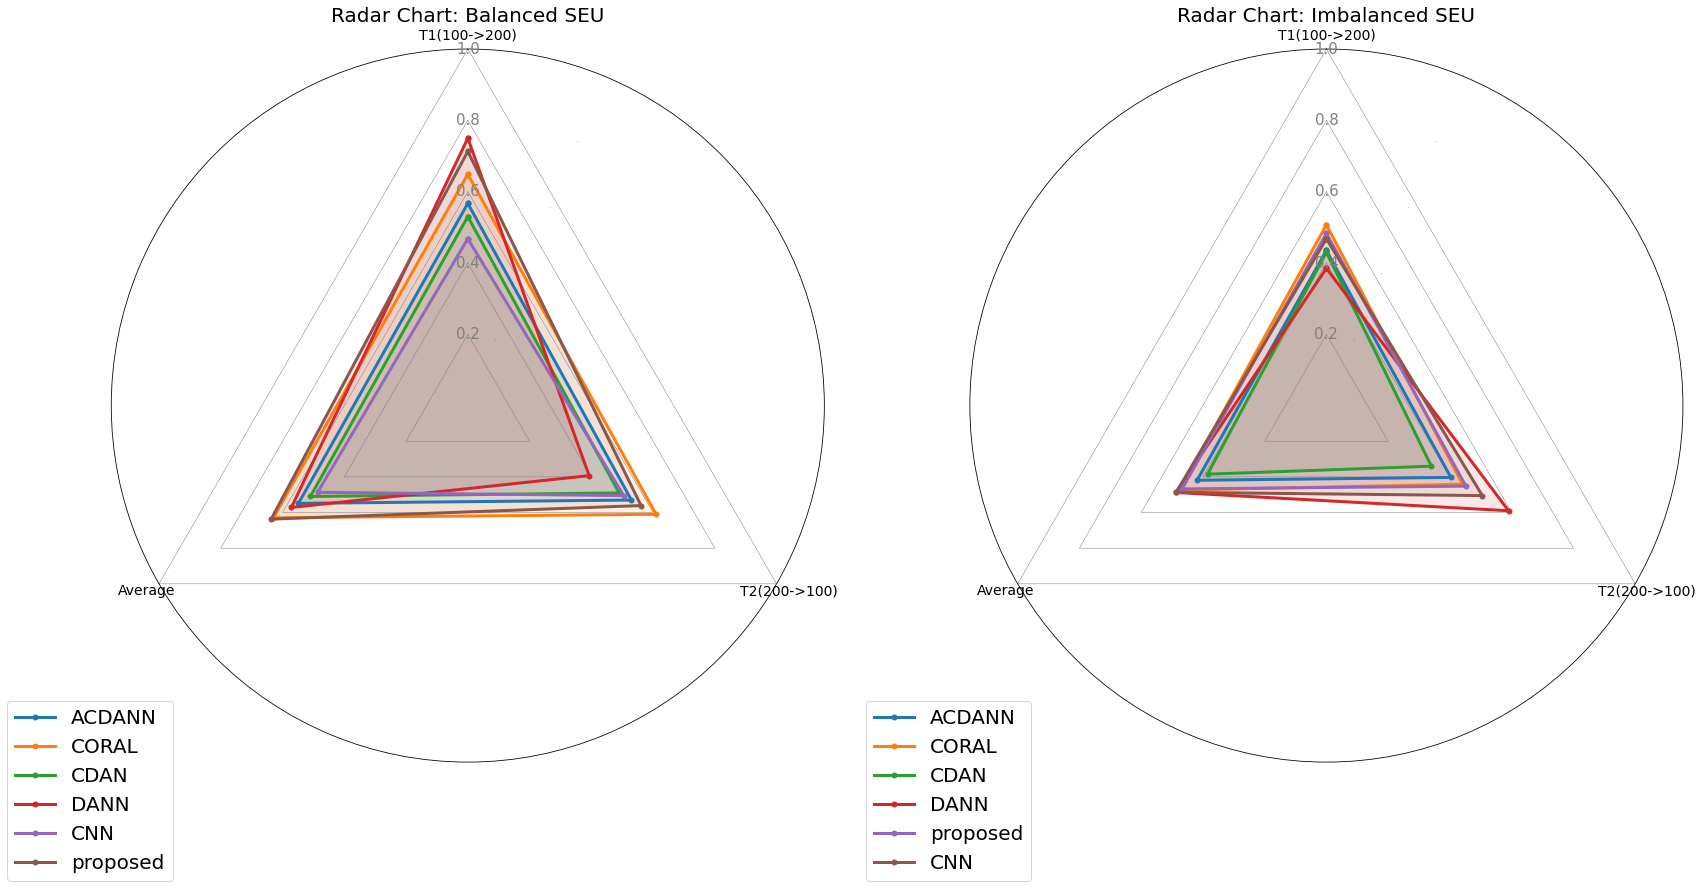

In [4]:
#SEU 
# train 5110개 (클래스 10개, 각 클래스는 511개)
# unlabeld target 2550개 (각 클래스는 255개) - unlabeld imbalanced target은 526개로 정상 (베어링정상,기어정상)을 제외한 결함들은 1퍼센트씩 존재 정상 255개씩, 나머지 8개 클래스는 2개씩있음
# eval target 2550개 (각 클래스는 255개)


path = "dsym2894/SEU_NEW"
df1 = fetch_runs_summary(path)

path = "dsym2894/SEU_imba"
df2 = fetch_runs_summary(path)

# 레이더 차트 그리기
fig, axs = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=dict(polar=True))
plot_radar_chart(df1, 'Radar Chart: Balanced SEU', fig, axs[0])
plot_radar_chart(df2, 'Radar Chart: Imbalanced SEU', fig, axs[1])

plt.tight_layout()
plt.show()

In [5]:
# 고려사항

'''
unlabeld target pseudo label로 바꿔줘야함
unlabeld target pseudo label의 비율과 실제 비율 비교
pseudo label의 confidence를 반영하여 batch sampler에 웨이트주기
이때 augmentation 고려
end to end 고민
반복실험 비교 (seed가 바뀌면 unlabeld 데이터들도 바뀜)
베이스라인 
하이퍼 파라미터
기존 imba모델과 비교 필요
데이터 사이즈 고려


'''

'\nunlabeld target pseudo label로 바꿔줘야함\nunlabeld target pseudo label의 비율과 실제 비율 비교\npseudo label의 confidence를 반영하여 batch sampler에 웨이트주기\n이때 augmentation 고려\nend to end 고민\n반복실험 비교\n베이스라인 \n하이퍼 파라미터\n기존 imba모델과 비교 필요\n데이터 사이즈 고려\n\n\n\n\n\n\n'